In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import random
import numpy as np
import torch
from PIL import Image
import open_clip
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from transformers import pipeline

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip

import psycopg2

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline


In [11]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
RECORD_IDS_TRAINING_SET = PARENT + os.getenv("RECORD_IDS_TRAINING_SET")

WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
WRITTEN_CAPTIONS_TRAINING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TRAINING_SET")

MERGED_DATA_VALIDATION_SET = PARENT + os.getenv("MERGED_DATA_VALIDATION_SET")
MERGED_DATA_TESTING_SET = PARENT + os.getenv("MERGED_DATA_TESTING_SET")
MERGED_DATA_TRAINING_SET = PARENT + os.getenv("MERGED_DATA_TRAINING_SET")

In [12]:
def fixPath(path):
    return path.replace(".././", "../")

filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = filtered_data_downloaded[
        filtered_data_downloaded["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [13]:
#setName = "validation"
setName = "validation"
DATA = None
if setName == "validation":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_VALIDATION_SET)
elif setName == "testing":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_TESTING_SET)
elif setName == "training":
    DATA = pd.read_csv(WRITTEN_CAPTIONS_TRAINING_SET)
DATA

,recordID,category,focus,caption
0,5002,Tableau,luminosity,Lumineux
1,10900,Tableau,luminosity,Lumineux
2,5510,Dessin,luminosity,Sombre
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon..."
4,7689,Tableau,emotion,"Peur, Colère"
...,...,...,...,...
903,4072,Tableau,content,"Portrait d'une jeune femme qui lit un livre, v..."
904,1294,Tableau,emotion,Peur
905,482,Tableau,colors,Couleurs sombres
906,7099,Tableau,luminosity,Neutre


In [14]:
DATA[DATA["focus"]=="content"].head(10)["caption"].to_list()

['Un paysage avec un ciel nuageux, un lac en fond et un arbre en avant plan',
 'Un musicien joue de la guitare, il est assis, il a une moustache et il est jeune',
 "Un portrait d'un homme avec un chapeau noir et un habt noir, une rose derrière, moustache, ciel et batiment",
 'Un vieil homme barbu, musclé, un baton dans la main',
 'Un panier avec pommes sur une table avec une tasse, des fleurs dans un vase rouge, des livres, du papier peint',
 'Une femme de dos dans une forêt qui marche entre les arbres',
 "Jésus qui parle à des personnes, un vieil homme avec une barbe blanche, une femme avec un foulard sur la tête, deux hommes d'église",
 'Un enfant debout avec deux femmes, un homme de dos, un vase',
 'Des personnes marchent de dos dans un port, le ciel nuageux, des mats en fond, des lampadaires',
 'Deux hommes qui regardent des livres, une femme avec un enfant, un marché dans la rue']

In [15]:
emotions = DATA[DATA["focus"]=="emotion"]
emotions_witout_comma = emotions[~emotions["caption"].str.contains(",")]
unique_emotions = emotions_witout_comma["caption"].unique()
unique_emotions

array(['Neutre', 'Peur', 'Tristesse', 'Joie', 'Surprise', 'Dégoût',
       'Colère'], dtype=object)

In [16]:
colors = DATA[DATA["focus"]=="colors"]
colors_witout_comma = colors[~colors["caption"].str.contains(",")]
unique_colors = colors_witout_comma["caption"].unique()
unique_colors

array(['Neutral', 'Noir et blanc<br>(bicolor)', 'Couleurs vives',
       'Couleurs sombres', 'Neutre', 'Teinte rouge', 'Teinte verte',
       'Teinte bleue'], dtype=object)

In [17]:
luminances = DATA[DATA["focus"]=="luminosity"]
luminances_witout_comma = luminances[~luminances["caption"].str.contains(",")]
unique_luminances = luminances_witout_comma["caption"].unique()
unique_luminances

array(['Lumineux', 'Sombre', 'Neutre'], dtype=object)

In [45]:
emotions_translations = {
    "fr": {
        "Peur": "Émotion peur",
        "Joie": "Émotion joie",
        "Surprise": "Émotion surprise",
        "Neutre": "Émotion neutre",
        "Tristesse": "Émotion Tristesse",
        "Colère": "Émotion Colère",
        "Dégoût": "Émotion dégoût",
    },
    "en": {
        "Peur": "Fear emotion",
        "Joie": "Joy emotion",
        "Surprise": "Surprise emotion",
        "Neutre": "Neutral emotion",
        "Tristesse": "Sadness emotion",
        "Colère": "Anger emotion",
        "Dégoût": "Disgust emotion",
    },
    "nl": {
        "Peur": "Angst emotie",
        "Joie": "Vreugde-emotie",
        "Surprise": "Verrast emotie",
        "Neutre": "Emotie neutraal",
        "Tristesse": "Verdriet emotie",
        "Colère": "Boosheid emotie",
        "Dégoût": "Walging emotie",
    },
}

def translate_emotions(emotions, lang):
    emotions = emotions.split(", ")
    return [emotions_translations[lang][emotion] for emotion in emotions]

test_set = [
    "Peur, Joie",
    "Joie",
    "Surprise, Neutre",
    "Neutre",
    "Tristesse",
    "Colère",
    "Dégoût"
]
for emotion in test_set:
    print(f"For emotion {emotion}:")
    print("   FR:", translate_emotions(emotion, "fr"))
    print("   EN:", translate_emotions(emotion, "en"))
    print("   NL:", translate_emotions(emotion, "nl"))

For emotion Peur, Joie:
   FR: ['Émotion peur', 'Émotion joie']
   EN: ['Fear emotion', 'Joy emotion']
   NL: ['Angst emotie', 'Vreugde-emotie']
For emotion Joie:
   FR: ['Émotion joie']
   EN: ['Joy emotion']
   NL: ['Vreugde-emotie']
For emotion Surprise, Neutre:
   FR: ['Émotion surprise', 'Émotion neutre']
   EN: ['Surprise emotion', 'Neutral emotion']
   NL: ['Verrast emotie', 'Emotie neutraal']
For emotion Neutre:
   FR: ['Émotion neutre']
   EN: ['Neutral emotion']
   NL: ['Emotie neutraal']
For emotion Tristesse:
   FR: ['Émotion Tristesse']
   EN: ['Sadness emotion']
   NL: ['Verdriet emotie']
For emotion Colère:
   FR: ['Émotion Colère']
   EN: ['Anger emotion']
   NL: ['Boosheid emotie']
For emotion Dégoût:
   FR: ['Émotion dégoût']
   EN: ['Disgust emotion']
   NL: ['Walging emotie']


In [50]:
colors_translations = {
    "fr": {
        "Noir et blanc<br>(bicolor)": {
            False: "Couleur noir et blanc",
            True: "Bicolore",
        },
        "Couleurs sombres": "Couleurs sombres",
        "Couleurs vives": "Couleurs vives",
        "Teinte rouge": "Couleur rouge",
        "Neutral": "Couleur neutre", "Neutre": "Couleur neutre", # Error in the front caused this...
        "Teinte verte": "Couleur verte",
        "Teinte bleue": "Couleur bleue",
    },
    "en": {
        "Noir et blanc<br>(bicolor)": {
            False: "Black and white color",
            True:  "Bicolor",
        },
        "Couleurs sombres": "Dark colors",
        "Couleurs vives": "Bright colors",
        "Teinte rouge": "Red color",
        "Neutral": "Neutral color", "Neutre": "Neutral color", # Error in the front caused this...
        "Teinte verte": "Green color",
        "Teinte bleue": "Blue color",
    },
    "nl": {
        "Noir et blanc<br>(bicolor)": {
            False: "Zwart-wit kleur",
            True:  "Bicolor",
        },
        "Couleurs sombres": "Donkere kleuren",
        "Levendige kleuren": "Heldere kleuren",
        "Teinte rouge": "Rode kleur", 
        "Neutral": "Neutrale kleur", "Neutre": "Neutrale kleur", # Error in the front caused this...
        "Teinte verte": "Groene kleur",
        "Blauwe teint": "Blauwe kleur",
    },
}

def translate_colors(colors, lang):
    colors = colors.split(", ")
    hasTint = False
    for color in colors:
        if "Teinte" in color:
            hasTint = True
            break
    
    translated_colors = []
    for color in colors:
        if color=="Noir et blanc<br>(bicolor)":
            translated_colors.append(colors_translations[lang][color][hasTint])
        else:
            translated_colors.append(colors_translations[lang][color])

    return translated_colors

test_set = [
    "Neutral",
    "Noir et blanc<br>(bicolor)",
    "Noir et blanc<br>(bicolor), Teinte rouge",
    "Couleurs sombres",
]
for color in test_set:
    print(f"For color {color}:")
    print("   FR:", translate_colors(color, "fr"))
    print("   EN:", translate_colors(color, "en"))
    print("   NL:", translate_colors(color, "nl"))

For color Neutral:
   FR: ['Couleur neutre']
   EN: ['Neutral color']
   NL: ['Neutrale kleur']
For color Noir et blanc<br>(bicolor):
   FR: ['Couleur noir et blanc']
   EN: ['Black and white color']
   NL: ['Zwart-wit kleur']
For color Noir et blanc<br>(bicolor), Teinte rouge:
   FR: ['Bicolore', 'Couleur rouge']
   EN: ['Bicolor', 'Red color']
   NL: ['Bicolor', 'Rode kleur']
For color Couleurs sombres:
   FR: ['Couleurs sombres']
   EN: ['Dark colors']
   NL: ['Donkere kleuren']


In [20]:
luminances_translations = {
    "fr": {
        "Neutre": "Luminosité neutre",
        "Lumineux": "Luminosité lumineuse",
        "Sombre": "Luminosité sombre",
    },
    "en": {
        "Neutre": "Neutral luminosity",
        "Lumineux": "Bright luminosity",
        "Sombre": "Dark luminosity",
    },
    "nl": {
        "Neutre": "Neutrale helderheid",
        "Lumineux": "Heldere helderheid",
        "Sombre": "Donkere helderheid",
    },
}

def translate_luminosities(luminosities, lang):
    luminosities = luminosities.split(", ")
    return [luminances_translations[lang][luminosity] for luminosity in luminosities]

test_set = [
    "Neutre",
    "Lumineux",
    "Sombre",
]

for luminosity in test_set:
    print(f"For luminosity {luminosity}:")
    print("   FR:", translate_luminosities(luminosity, "fr"))
    print("   EN:", translate_luminosities(luminosity, "en"))
    print("   NL:", translate_luminosities(luminosity, "nl"))

For luminosity Neutre:
   FR: ['Luminosité neutre']
   EN: ['Neutral luminosity']
   NL: ['Neutrale helderheid']
For luminosity Lumineux:
   FR: ['Luminosité lumineuse']
   EN: ['Bright luminosity']
   NL: ['Heldere helderheid']
For luminosity Sombre:
   FR: ['Luminosité sombre']
   EN: ['Dark luminosity']
   NL: ['Donkere helderheid']


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
# Load the models
tokenizer = transformers.AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32") # All tokenizer tokenize the same 

# FR --> EN
pipeline_fr_en = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en", device=device)

# EN --> NL
pipeline_en_nl = pipeline("translation", model="Helsinki-NLP/opus-mt-en-nl", device=device) # We cannot translate from French to Dutch using opus

Device set to use cuda
Device set to use cuda


In [42]:
MLENGTH = 128

def translate__FR_EN(text):
    return pipeline_fr_en(text, max_length=MLENGTH)[0]['translation_text']

def translate__EN_NL(text):
    return pipeline_en_nl(text, max_length=MLENGTH)[0]['translation_text']

def translate(text, lang):
    if lang == "en":
        return translate__FR_EN(text)
    elif lang == "nl":
        return translate__EN_NL(text)
    elif lang == "fr":
        return text
    else:
        raise ValueError("Language not supported. Use 'en' or 'nl'.")

def get_tokenized_text(text):
    return len(tokenizer(text)["input_ids"])

# Test
example_fr = "Bonjour, comment ça va ?"
translated_en = translate(example_fr, "en")
translated_nl = translate(translated_en, "nl")
print(f"Original (FR): {example_fr}")
print(f"Translated to EN: {translated_en}")
print(f"Translated to NL: {translated_nl}")
print(f"Tokenized length (FR): {get_tokenized_text(example_fr)}")
print(f"Tokenized length (EN): {get_tokenized_text(translated_en)}")
print(f"Tokenized length (NL): {get_tokenized_text(translated_nl)}")

Original (FR): Bonjour, comment ça va ?
Translated to EN: Hello, how are you?
Translated to NL: Hallo, hoe gaat het?
Tokenized length (FR): 8
Tokenized length (EN): 8
Tokenized length (NL): 10


In [43]:
def translateRow(fr_row, lang):
    focus = fr_row["focus"]
    if focus=="content":
        return translate(fr_row["caption"], lang)
    elif focus=="emotion":
        return translate_emotions(fr_row["caption"], lang)
    elif focus=="colors":
        return translate_colors(fr_row["caption"], lang)
    elif focus=="luminosity":
        return translate_luminosities(fr_row["caption"], lang)
    else:
        raise ValueError("Focus not supported. Use 'content', 'emotion', 'colors' or 'luminosity'.")

In [65]:
def getTokenizedLength(row):
    focus = row["focus"]
    caption = row["caption"]
    others = row["others"]

    if focus!="content":
        others = ", ".join(others)
        full = f"{caption}, {others}"
    else:
        full = caption
    
    return get_tokenized_text(full)

In [37]:
DATA

,recordID,category,focus,caption
0,5002,Tableau,luminosity,Lumineux
1,10900,Tableau,luminosity,Lumineux
2,5510,Dessin,luminosity,Sombre
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon..."
4,7689,Tableau,emotion,"Peur, Colère"
...,...,...,...,...
903,4072,Tableau,content,"Portrait d'une jeune femme qui lit un livre, v..."
904,1294,Tableau,emotion,Peur
905,482,Tableau,colors,Couleurs sombres
906,7099,Tableau,luminosity,Neutre


In [ ]:
# Create the dataset
three_lang_dataset = None
langs = ["fr", "en", "nl"]
english_captions = {}
for lang in langs:
    dataset_lang = DATA.copy()

    print(f"Translating to {lang}...")

    # Order so that focus=="content" is first
    dataset_lang["isFocusContent"] = dataset_lang["focus"].apply(lambda x: 1 if x=="content" else 0)
    dataset_lang = dataset_lang.sort_values(by="isFocusContent", ascending=False).drop(columns=["isFocusContent"])
    # Reset the index
    dataset_lang = dataset_lang.reset_index(drop=True)

    captions = []
    others = []
    translated_captions_per_recordID = {}
    tqdm_bar = tqdm(total=len(dataset_lang), desc=f"Translating to {lang}", position=0, leave=True)
    for index, row in dataset_lang.iterrows():

        recordID = row["recordID"]
        focus = row["focus"]
        caption = row["caption"]

        if lang=="nl" and focus=="content":
            # If we are translating to Dutch and the focus is content, we need to get the English caption (EN --> NL)
            caption = english_captions[recordID]
            row["caption"] = caption
            
        translation = translateRow(row, lang)
        
        if focus=="content":
            captions.append(translation)
            others.append(np.nan)
            translated_captions_per_recordID[recordID] = translation
            if lang=="en":
                english_captions[recordID] = translation
        else:
            captions.append(translated_captions_per_recordID[recordID])
            others.append(translation)

        tqdm_bar.update(1)

    dataset_lang["caption"] = captions
    dataset_lang["others"] = others

    # Add the language column
    dataset_lang["lang"] = lang

    # Append to the three_lang_dataset DataFrame
    if three_lang_dataset==None:
        three_lang_dataset = dataset_lang
    else:
        three_lang_dataset = pd.concat([three_lang_dataset, dataset_lang], ignore_index=True)

three_lang_dataset

Translating to fr...


Translating to en:   4%|▍         | 38/908 [00:14<05:22,  2.70it/s]


Translating to en...


Translating to en:   5%|▌         | 46/908 [00:08<02:01,  7.08it/s]

KeyboardInterrupt: 

In [18]:
def plot_histogram_per_focus(df, savename):
    # 2x2 plot, one histogram per focus
    ROWS_PER_FOCUS = {}
    min_token = 0
    max_token = -1

    for focus in df["focus"].unique():
        rows_for_focus = df[df["focus"]==focus]
        ROWS_PER_FOCUS[focus] = rows_for_focus
        max_token = max(max_token, rows_for_focus["length_tokenization"].max())

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    fig.suptitle('Tokenized length of captions per focus')
    for i, focus in enumerate(ROWS_PER_FOCUS.keys()):
        ax = axs[i//2, i%2]
        rows_for_focus = ROWS_PER_FOCUS[focus]
        mean = rows_for_focus["length_tokenization"].mean()
        ax.hist(rows_for_focus["length_tokenization"], bins=15, range=(min_token, max_token))
        ax.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f"mean: {mean:.2f}")
        ax.set_title(focus)
        ax.set_xlabel("Tokenized length")
        ax.set_ylabel("Number of captions")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(FOLDER_FIGURES + f"length_tokenization_{setName}_{savename}.pdf")
    plt.show()

Since we assume that a caption with an emotion/a color or a luminosity added is a concatenation of both, we will create such a dataset:

In [19]:
def edgeCaseEmotion(emotion):
    if emotion=="Neutre":
        emotion = "émotion neutre"
    return emotion

def edgeCaseColor(color):
    if color=="Neutre":
        color = None # The color is neutral in the sense that we do not want to specify it
    return color

def edgeCaseLuminosity(luminosity):
    if luminosity=="Neutre":
        luminosity = None # The luminosity is neutral in the sense that we do not want to specify it
    return luminosity

In [20]:
MERGED_DATA = pd.DataFrame(columns=DATA.columns)
tokenizer = tokenizers[selected_models[0]]
for i in tqdm(range(len(DATA))):
    row = DATA.iloc[i]

    recordID = row["recordID"]
    category = row["category"]
    focus = row["focus"]
    caption = row["caption"]
    length_tokenization = row["length_tokenization"]

    newRow = None

    if focus=="content":
        # Keep the caption as such
        MERGED_DATA.loc[len(MERGED_DATA)] = row.to_list()
    elif focus=="emotion":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the emotions by ", "
        emotions = caption.split(", ")
        emotions = [edgeCaseEmotion(emotion) for emotion in emotions]

        for emotion in emotions:
            mergedCaption = f"{caption_content}, {emotion}"
            newRow = [
                recordID,
                category,
                focus, # emotion
                mergedCaption,
                len(tokenizer.encode(mergedCaption))
            ]
            MERGED_DATA.loc[len(MERGED_DATA)] = newRow
    elif focus=="colors":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the colors by ", "
        colors = caption.split(", ")
        colors = [edgeCaseColor(color) for color in colors]
        # Remove empty strings
        colors = list(filter(None, colors))
        if len(colors)==0:
            # No colors specified
            continue

        colors = ", ".join(colors)

        mergedCaption = f"{caption_content}, {colors}"
        newRow = [
            recordID,
            category,
            focus, # colors
            mergedCaption,
            len(tokenizer.encode(mergedCaption))
        ]
        MERGED_DATA.loc[len(MERGED_DATA)] = newRow
    elif focus=="luminosity":
        # Get the row with focus content for this recordID
        content_row = DATA[(DATA["recordID"]==recordID) & (DATA["focus"]=="content")].iloc[0]
        caption_content = content_row["caption"]

        # Split the luminosities by ", "
        luminosities = caption.split(", ")
        luminosities = caption.split(", ")
        luminosities = [edgeCaseLuminosity(luminosity) for luminosity in luminosities]
        # Remove empty strings
        luminosities = list(filter(None, luminosities))
        if len(luminosities)==0:
            # No luminosities specified
            continue

        luminosities = ", ".join(luminosities)

        mergedCaption = f"{caption_content}, {luminosities}"
        newRow = [
            recordID,
            category,
            focus, # luminosity
            mergedCaption,
            len(tokenizer.encode(mergedCaption))
        ]
        MERGED_DATA.loc[len(MERGED_DATA)] = newRow

# Save the merged data
if setName=="validation":
    MERGED_DATA.to_csv(MERGED_DATA_VALIDATION_SET, index=False)
elif setName=="testing":
    MERGED_DATA.to_csv(MERGED_DATA_TESTING_SET, index=False)
else:
    MERGED_DATA.to_csv(MERGED_DATA_TRAINING_SET, index=False)

MERGED_DATA

100%|██████████| 908/908 [00:00<00:00, 932.24it/s]


,recordID,category,focus,caption,length_tokenization
0,7059,Dessin,content,Un texte entouré d'enfants anges avec des femm...,25
1,1352,Tableau,emotion,"Une maison dans une forêt aux arbres sombres, ...",39
2,4144,Tableau,emotion,"Un chemin de terre entre des collines sombres,...",33
3,4144,Tableau,emotion,"Un chemin de terre entre des collines sombres,...",32
4,4070,Tableau,content,"Couloir d'une maison avec un escalier, porte o...",26
...,...,...,...,...,...
977,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,51
978,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,49
979,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,49
980,1202,Tableau,colors,"Des hommes qui parlent à un sultan, des soldat...",34


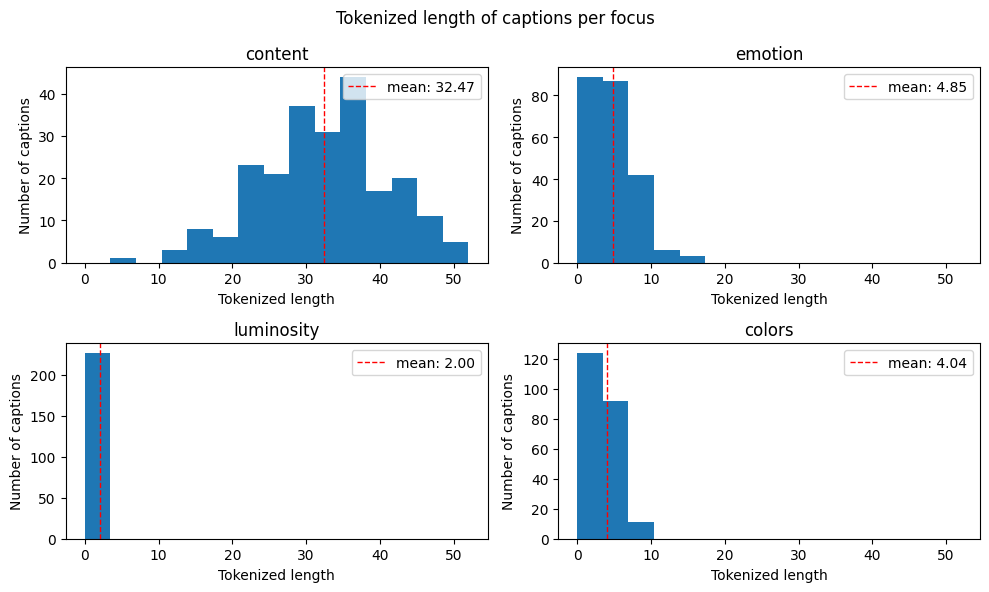

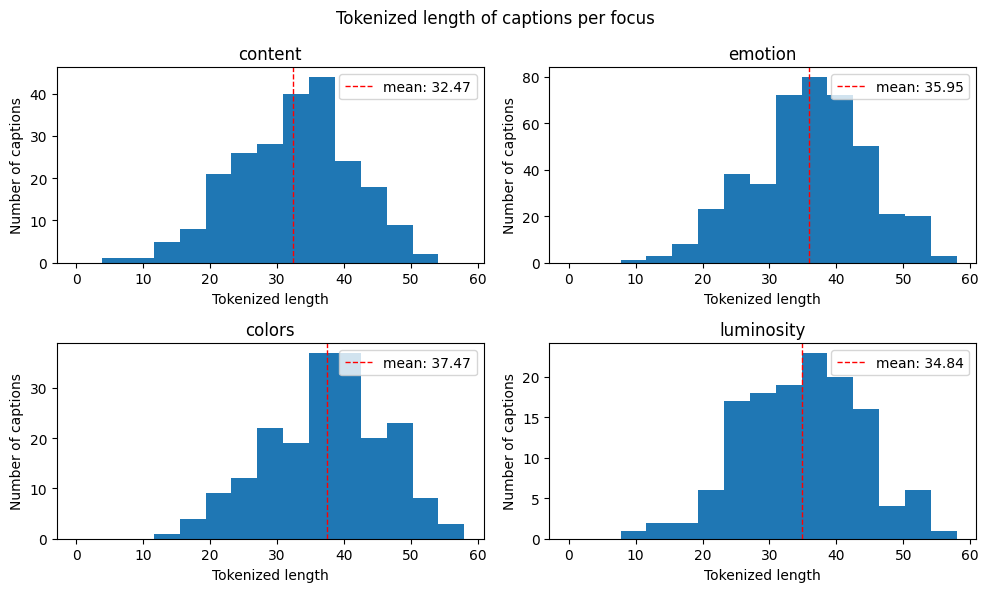

In [21]:
plot_histogram_per_focus(DATA, "original")
plot_histogram_per_focus(MERGED_DATA, "merged")

In [22]:
merged_caption_table = pd.DataFrame(columns=["Version", "Content (%)", "Emotion (%)", "Colors (%)", "Luminosity (%)"])
focus_uniques = ["Content", "Emotion", "Colors", "Luminosity"]

# Original/Raw data
merged_caption_table.loc[len(merged_caption_table)] = [
    "Original/Raw",
    len(DATA[DATA["focus"]=="content"])/len(DATA),
    len(DATA[DATA["focus"]=="emotion"])/len(DATA),
    len(DATA[DATA["focus"]=="colors"])/len(DATA),
    len(DATA[DATA["focus"]=="luminosity"])/len(DATA)
]

# Merged data
merged_caption_table.loc[len(merged_caption_table)] = [
    "Merged",
    len(MERGED_DATA[MERGED_DATA["focus"]=="content"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="emotion"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="colors"])/len(MERGED_DATA),
    len(MERGED_DATA[MERGED_DATA["focus"]=="luminosity"])/len(MERGED_DATA)
]

# Format the last 4 columns as percentages
for focus in focus_uniques:
    merged_caption_table[focus + " (%)"] = merged_caption_table[focus + " (%)"].apply(lambda x: f"{x*100:.2f}%")

# Save the table
merged_caption_table.to_csv(FOLDER_TABLE + f"merged_caption_table_{setName}.csv", index=False)
merged_caption_table

,Version,Content (%),Emotion (%),Colors (%),Luminosity (%)
0,Original/Raw,25.00%,25.00%,25.00%,25.00%
1,Merged,23.12%,43.28%,19.86%,13.75%


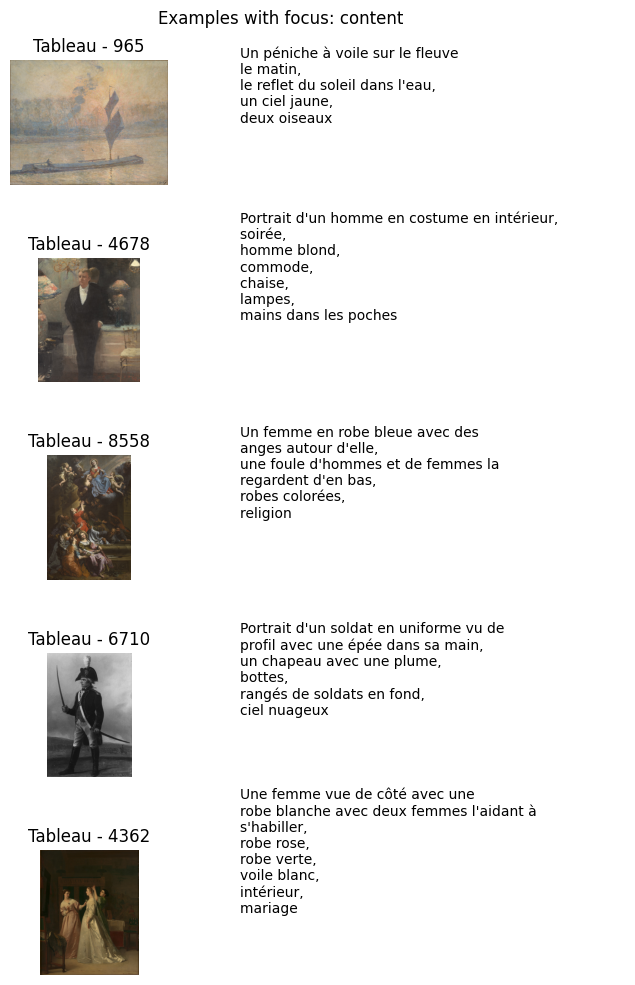

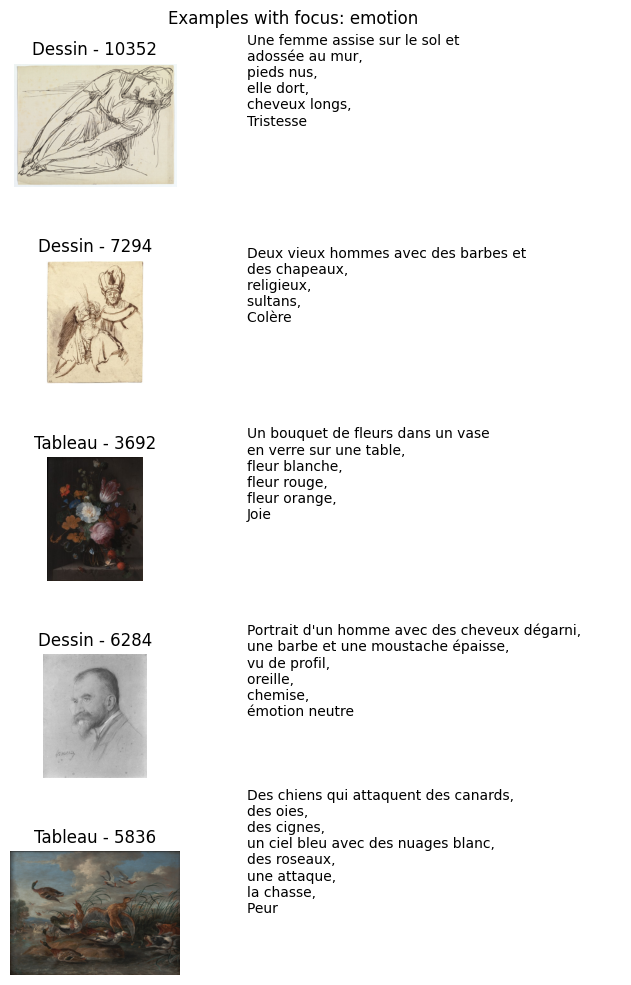

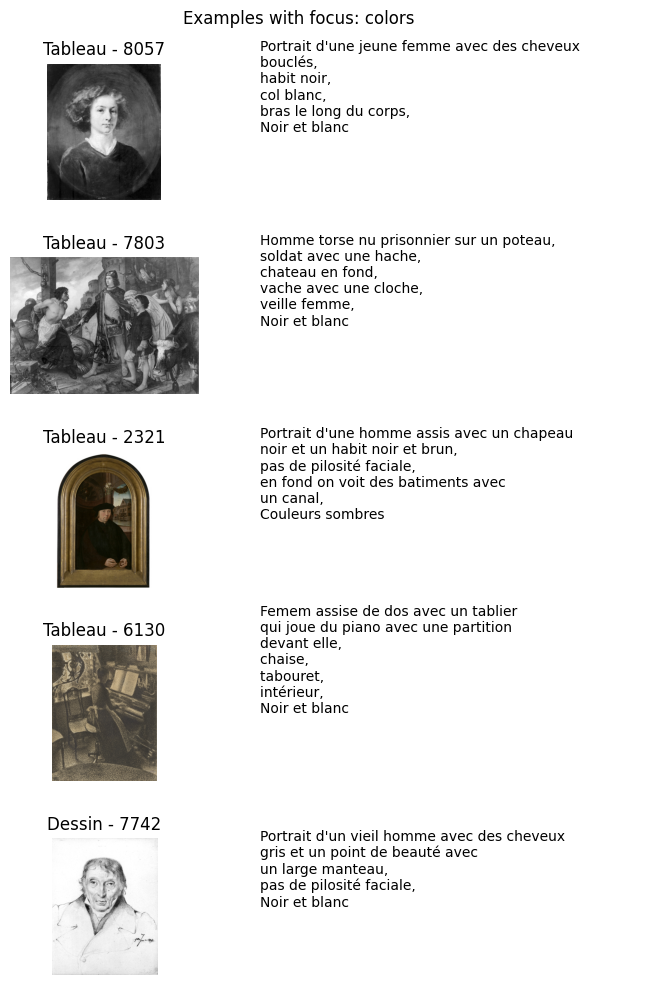

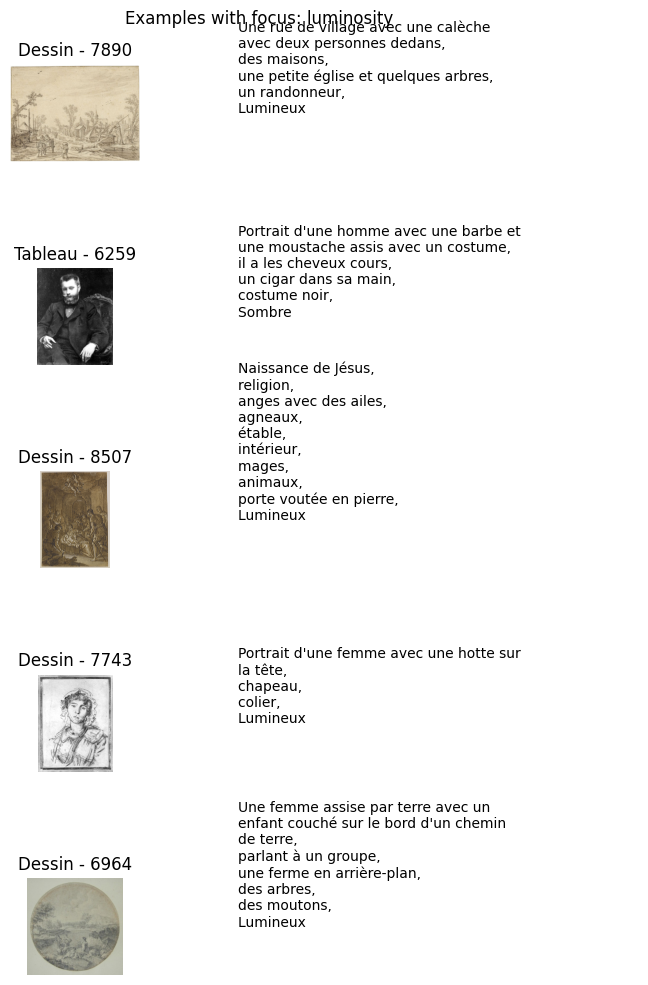

In [23]:
def formatLine(raw, maxWords=8):
    # raw is a string, add \n every maxWords words
    words = raw.split(" ")
    lines = []
    line = ""
    for word in words:
        if len(line.split(" "))==maxWords:
            lines.append(line)
            line = ""
        line += word + " "
    lines.append(line)
    return "\n".join(lines)

def formatCaption(caption):
    caption = caption.replace(", ", ",\n")
    return "\n".join([formatLine(line) for line in caption.split("\n")])

def show_N_examples_with_focus(data, N, focus):
    rows = data[data["focus"]==focus].sample(N)
    # Plot with N rows, each row contains the image on the left and the caption on the right
    fig, axs = plt.subplots(N, 2, figsize=(8, 2*N))
    fig.suptitle(f"Examples with focus: {focus}")
    for i in range(N):
        row = rows.iloc[i]
        recordID = row["recordID"]
        category = row["category"]
        caption = row["caption"]
        image_path = get_image_path_from_recordID(recordID)
        image = Image.open(image_path)
        axs[i, 0].imshow(image, cmap="gray")
        axs[i, 0].axis("off")
        axs[i, 0].set_title(f"{category} - {recordID}")
        axs[i, 1].text(0, 0.5, formatCaption(caption), fontsize=10)
        axs[i, 1].axis("off")
    plt.tight_layout()
    plt.savefig(FOLDER_FIGURES + f"examples_{focus}_{setName}.pdf")
    plt.show()

for focus in MERGED_DATA["focus"].unique():
    show_N_examples_with_focus(MERGED_DATA, 5, focus)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
selected_models = [
    "convnext_base",
    "ViT-B-32",
    "ViT-g-14",
    "ViT-L-14-quickgelu",
    "ViT-H-14-quickgelu",
    "ViT-H-14-378-quickgelu",
]

In [26]:
selected_model = selected_models[2]
model, _, preprocess = open_clip.create_model_and_transforms(selected_model)
model = model.to(device)
model.eval()
tokenizer = open_clip.get_tokenizer(selected_model)

In [27]:
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity

class ImageTextDataset(Dataset):
    def __init__(self, dataframe, preprocess):
        self.dataframe = dataframe
        self.preprocess = preprocess

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        path = get_image_path_from_recordID(row['recordID']) 
        image = Image.open(path)
        image = self.preprocess(image)
        
        text = row['caption']
        return image, text

dataset = ImageTextDataset(MERGED_DATA, preprocess)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

print(len(dataset), len(dataloader))

982 62


In [28]:
# Compute features
image_features_list = []
text_features_list = []

with torch.no_grad():
    for images, texts in tqdm(dataloader):
        # Process images
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
        image_features_list.append(image_features.cpu())

        # Process texts
        tokenized_texts = tokenizer(texts).to(device)
        text_features = model.encode_text(tokenized_texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
        text_features_list.append(text_features.cpu())

# Combine all features
image_features = torch.cat(image_features_list, dim=0)
text_features = torch.cat(text_features_list, dim=0)

# Convert to numpy arrays for cosine similarity calculation
image_features_np = image_features.numpy()
text_features_np = text_features.numpy()

100%|██████████| 62/62 [01:23<00:00,  1.34s/it]


In [29]:
# Compute cosine similarity for each row
cosine_similarities = [
    cosine_similarity(
        image_features_np[i].reshape(1, -1), 
        text_features_np[i].reshape(1, -1)
    )[0, 0]
    for i in range(len(MERGED_DATA))
]

# Add similarities to the DataFrame
MERGED_DATA['cosine_similarity'] = cosine_similarities
MERGED_DATA['cosine_similarity'].describe()

count    982.000000
mean       0.011251
std        0.017262
min       -0.039775
25%       -0.001032
50%        0.010003
75%        0.024229
max        0.068919
Name: cosine_similarity, dtype: float64

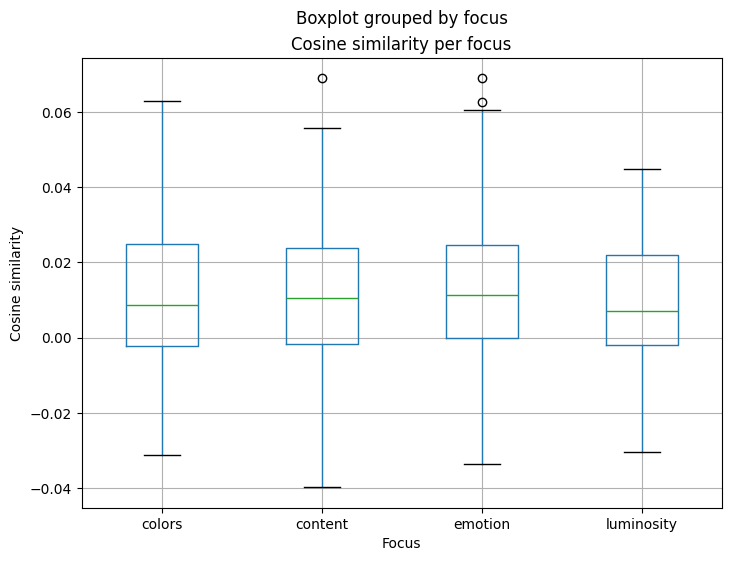

: 

In [31]:
# Boxplot of cosine similarities per focus
fig, ax = plt.subplots(figsize=(8, 6))
ax = MERGED_DATA.boxplot(column='cosine_similarity', by='focus', ax=ax)
plt.title('Cosine similarity per focus')
plt.ylabel('Cosine similarity')
plt.xlabel('Focus')
plt.savefig(FOLDER_FIGURES + f"cosine_similarity_per_focus_{setName}.pdf")
plt.show()